# TM10007 Assignment Group 5

Anna Walstra (4543653), Thijs van Deudekom (4452852) and Suus van Loosbroek (4465318)

In [0]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/annawalstra/tm10007_Group5.git
!pip install simpleITK

## **Data loading and cleaning**



In [0]:
# General packages
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets as ds
import seaborn

# Classifiers
from sklearn import model_selection
from sklearn import metrics
from sklearn import feature_selection 
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import svm
from sklearn import decomposition
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

# Classifiers and kernels
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA, KernelPCA
from sklearn.kernel_approximation import RBFSampler
from sklearn.metrics.pairwise import rbf_kernel, sigmoid_kernel
from sklearn.decomposition import PCA
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

# Metrics
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve
from sklearn.metrics import classification_report

# Data loading functions. Uncomment the one you want to use
from adni.load_data import load_data
data = load_data()
print(f'Original data:')
print(f'The number of spamples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

# Creating X and Y 
X = data.loc[:, data.columns != 'label']
Y = data['label']
print(f'Data orientation:')
print(X.head())
print(f'Labels in Y: {Y.head()}')

# Binarize Y labels
y_bin = preprocessing.label_binarize(Y, ['CN','AD'])
y_bin = [i[0] for i in y_bin]
print(f'Labels binarized: {y_bin[:10]}')

# Deleting features with only zeros
X = X.loc[:, (X != 0).any(axis=0)]
print(f'DATA CLEANING')
print(f'Deleting columns filled with zeros:')
print(f'The number of spamples: {len(X.index)}')
print(f'The number of columns: {len(X.columns)}')

# Split the dataset in develop and test part
X_dev, X, Y_dev, Y = model_selection.train_test_split(X, y_bin, test_size=0.9, stratify=y_bin)

# Split the training data in train and test part
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X_dev, Y_dev, test_size=0.2, stratify=Y_dev)

# Crossvalidation for parameter tuning
cv_10fold = model_selection.StratifiedKFold(n_splits=10)

Original data:
The number of spamples: 855
The number of columns: 268
Data orientation:
                     hf_energy  ...  vf_Frangi_inner_std_SR(1.0, 10.0)_SS2.0
ID                              ...                                         
0_002_S_0413_bl_0  5403.229408  ...                             4.207831e-10
0_002_S_0559_bl_0   922.459760  ...                             3.137258e-10
0_002_S_0619_bl_0  1674.765276  ...                             4.219847e-10
0_002_S_0685_bl_0  3443.797200  ...                             5.954654e-11
0_002_S_0816_bl_0   914.469846  ...                             4.174750e-10

[5 rows x 267 columns]
Labels in Y: ID
0_002_S_0413_bl_0    AD
0_002_S_0559_bl_0    AD
0_002_S_0619_bl_0    CN
0_002_S_0685_bl_0    AD
0_002_S_0816_bl_0    CN
Name: label, dtype: object
Labels binarized: [1, 1, 0, 1, 0, 0, 0, 0, 1, 1]
DATA CLEANING
Deleting columns filled with zeros:
The number of spamples: 855
The number of columns: 263


## **FEATURE SCALING**

We performed a Shapiro-Wilk test to check if the data is normally/distributed. This wasn't the case, so we decided not to use the robust scalars. 

In [0]:
# FEATURE SCALING

# Options: RobustScaler, StandardScaler, MinMaxScaler

# Perform Shapiro-Wilk Test to check if the data is normally/Gaussian distributed
#from numpy.random import seed
#from numpy.random import randn
#from scipy.stats import shapiro
# seed the random number generator
#seed(1)
# generate univariate observations
#data = X_train
# normality test
#stat, p = shapiro(data)
#print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
#alpha = 0.05
#if p > alpha:
# print('Sample looks Gaussian (fail to reject H0)')
#else:
# print('Sample does not look Gaussian (reject H0)')
# Hier kwam uit dat de sample niet Gaussian is dus verder niet naar gekeken

# Chosen: Standard scaler 
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## **Feature Selection/Extration** Option 1

We tried L1 very briefly, but decided not to use this technique. We did plot the first two principle components to get an insight in the data.  

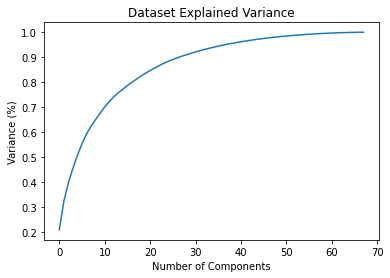

Nr. of components:37


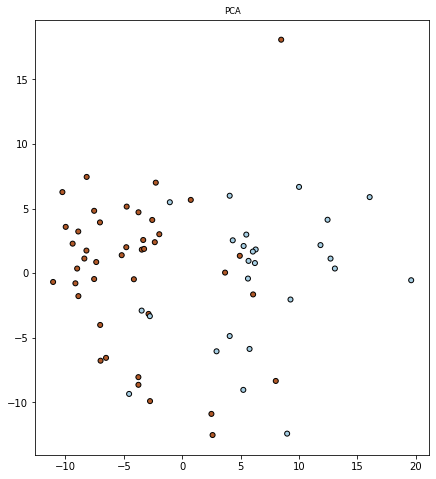

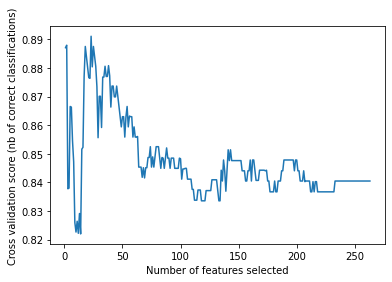

In [0]:
#Fitting the PCA algorithm with our Data
pca = PCA().fit(X_train_scaled)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Dataset Explained Variance')
plt.show()

# Perform a PCA
var = np.cumsum(pca.explained_variance_ratio_) 
n_components = np.where(var > 0.95)[0][0]
print(f"Nr. of components:{n_components}")

# Perform a PCA
pca = decomposition.PCA(n_components=n_components)
pca.fit(X_train_scaled)
X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

#Plot first feature PCA for visualization
fig = plt.figure(figsize=(24,8))
ax = fig.add_subplot(131)
ax.set_title("PCA", fontsize='small')
ax.scatter(X_train_pca[:, 0], X_train_pca[:, 1], marker='o', c=Y_train,
            s=25, edgecolor='k', cmap=plt.cm.Paired)

# # Use the selectfrommodel module: L1 Select all features with a weight above the median.
# from sklearn.feature_selection import SelectFromModel
# from sklearn.linear_model import Lasso, RidgeClassifier
# selector = SelectFromModel(estimator=Lasso(alpha=10**(-5)), threshold='median')
# selector.fit(X_train_scaled, Y_train)
# n_original = X_train_scaled.shape[1]
# X_train_L1 = selector.transform(X_train_scaled)
# X_test_L1 = selector.transform(X_test_scaled)
# n_selected = X_train_L1.shape[1]
# print(f"Selected {n_selected} from {n_original} features.")


# #Plot first feature L1 selection
#fig = plt.figure(figsize=(24,8))
#ax = fig.add_subplot(132)
#ax.set_title("L1", fontsize='small')
#ax.scatter(X_train_L1[:, 0], X_train_L1[:, 1], marker='o', c=Y_train,
        #     s=25, edgecolor='k', cmap=plt.cm.Paired)


# Recursive Feature Elimination (RFE)

# Create the RFE object and compute a cross-validated score
svc = svm.SVC(kernel="linear")

# classifications
rfecv = feature_selection.RFECV(
   estimator=svc, step=1, 
   cv=model_selection.StratifiedKFold(4),
   scoring='roc_auc')
rfecv.fit(X_train_scaled, Y_train)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()




##**FEATURE SELECTION option 2**

First features are selected based on their importance, calculated with a Random Forest classifier.
Secondly, PCA is performed and the remaining features contain 95% of the variance.

(68, 263)


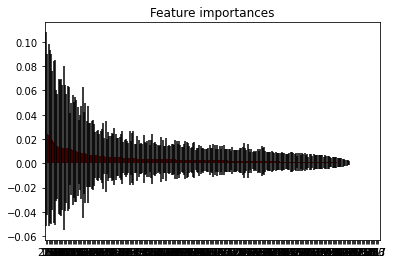

(68, 76)
Nr. of features after RF feature importance:76


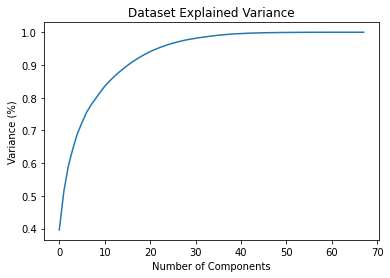

Nr. of features after PCA:26


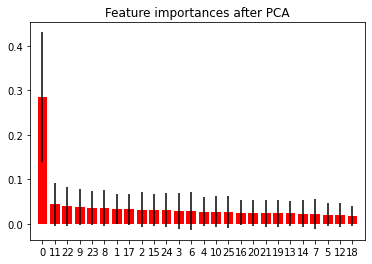

In [0]:
print(X_train_scaled.shape)

clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(X_train_scaled, Y_train)
clf.feature_importances_ 

# Plot the feature importances of the forest
importances = clf.feature_importances_ 
indices = np.argsort(importances)[::-1]
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train_scaled.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train_scaled.shape[1]), indices)
plt.xlim([-1, X_train_scaled.shape[1]])
plt.show()

model = SelectFromModel(clf, prefit=True, threshold= "1*mean")
X_new = model.transform(X_train_scaled)
X_new_test = model.transform(X_test_scaled)

print(X_new.shape) 
print(f"Nr. of features after RF feature importance:{X_new.shape[1]}")

#Fitting the PCA algorithm with our Data
pca = PCA().fit(X_new)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Dataset Explained Variance')
plt.show()

# Perform a PCA
var = np.cumsum(pca.explained_variance_ratio_) 
n_components = np.where(var > 0.97)[0][0]
print(f"Nr. of features after PCA:{n_components}")

# Perform a PCA
pca = decomposition.PCA(n_components=n_components)
pca.fit(X_new)
X_pca_train = pca.transform(X_new)
X_pca_test = pca.transform(X_new_test)

# Plot importances of PCA selected features
clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(X_pca_train, Y_train)
clf.feature_importances_ 

# Plot the feature importances of the forest
importances = clf.feature_importances_ 
indices = np.argsort(importances)[::-1]
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
plt.figure()
plt.title("Feature importances after PCA")
plt.bar(range(X_pca_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_pca_train.shape[1]), indices)
plt.xlim([-1, X_pca_train.shape[1]])
plt.show()

## KNN Classifier

This is performed to build the classifier and get an insight in the hyperparameters. 


Best leaf_size: 31
Best p: 1
Best n_neighbors: 34
KNeighborsClassifier(algorithm='auto', leaf_size=31, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=34, p=1,
                     weights='uniform')
              precision    recall  f1-score   support

           0       0.82      0.62      0.71       269
           1       0.79      0.91      0.85       415

    accuracy                           0.80       684
   macro avg       0.81      0.77      0.78       684
weighted avg       0.80      0.80      0.79       684

              precision    recall  f1-score   support

           0       0.83      0.57      0.67        67
           1       0.77      0.92      0.84       104

    accuracy                           0.78       171
   macro avg       0.80      0.75      0.76       171
weighted avg       0.79      0.78      0.77       171



<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

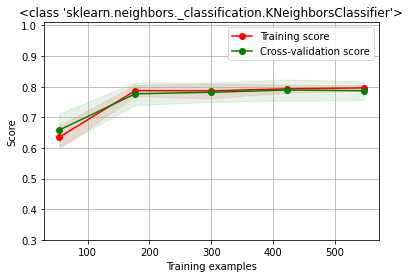

In [0]:
#Hyperparameters that we want to tune.
leaf_size = list(range(1,50))
n_neighbors = list(range(1,50))
p=[1,2]
hyperparameters = dict(n_neighbors=n_neighbors,leaf_size=leaf_size, p=p)

#Create kNN object
knn = neighbors.KNeighborsClassifier()

#Use RandomizedSearch to tune hyperparameters
random_search = model_selection.RandomizedSearchCV(knn, hyperparameters, cv=cv_10fold)

#Fit the model
best_model = random_search.fit(X_train_pca,Y_train)
clf = random_search.best_estimator_

#Print The value of best Hyperparameters
print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
print('Best p:', best_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])
print(clf)

# Test training dataset
y_pred_train = clf.predict(X_train_pca)
print(classification_report(Y_train, y_pred_train))

# Test test dataset
y_pred = clf.predict(X_test_pca)
print(classification_report(Y_test, y_pred))

#Learning curve
plt.show()
title = str(type(clf))
fig, ax = plt.subplots()
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
plot_learning_curve(clf, title, X_train_pca, Y_train, ax, ylim=(0.3, 1.01), cv=cv)

## KNN with Crossvalidation

This is performed to build the classifier and get an insight in the hyperparameters. 


Iteration nr. 1 with best hyperparameters:
Best leaf_size: 3
Best p: 1
Best n_neighbors: 35
Iteration nr. 2 with best hyperparameters:
Best leaf_size: 9
Best p: 1
Best n_neighbors: 40
Iteration nr. 3 with best hyperparameters:
Best leaf_size: 15
Best p: 1
Best n_neighbors: 44
Iteration nr. 4 with best hyperparameters:
Best leaf_size: 8
Best p: 1
Best n_neighbors: 39
Iteration nr. 5 with best hyperparameters:
Best leaf_size: 18
Best p: 1
Best n_neighbors: 48
Iteration nr. 6 with best hyperparameters:
Best leaf_size: 10
Best p: 1
Best n_neighbors: 40
Iteration nr. 7 with best hyperparameters:
Best leaf_size: 43
Best p: 1
Best n_neighbors: 48
Iteration nr. 8 with best hyperparameters:
Best leaf_size: 36
Best p: 1
Best n_neighbors: 24
Iteration nr. 9 with best hyperparameters:
Best leaf_size: 45
Best p: 1
Best n_neighbors: 47
Iteration nr. 10 with best hyperparameters:
Best leaf_size: 25
Best p: 1
Best n_neighbors: 41
Iteration nr. 11 with best hyperparameters:
Best leaf_size: 49
Best p: 1

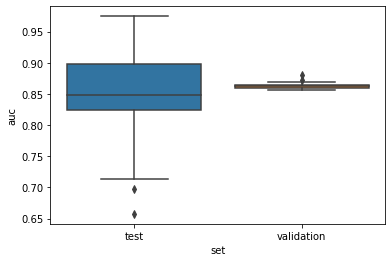

              precision    recall  f1-score   support

           0       0.79      0.63      0.70        67
           1       0.79      0.89      0.84       104

    accuracy                           0.79       171
   macro avg       0.79      0.76      0.77       171
weighted avg       0.79      0.79      0.78       171

0.7894736842105263


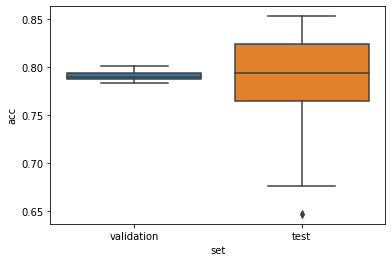

In [0]:
# Create a 20 fold stratified CV iterator
cv_20fold = model_selection.StratifiedKFold(n_splits=20)
results_kNN = []
results_acc_kNN = []
best_n_neighbors = []
num_kNN = 0

# Loop over the folds
for validation_index, test_index in cv_20fold.split(X_train_pca, Y_train):
    # Split the data properly
    X_validation = X_train_pca[validation_index]
    y_validation = np.array(Y_train)[validation_index]
    
    X_test = X_train_pca[test_index]
    y_test = np.array(Y_train)[test_index]

    # Hyperparameters that we want to tune. (kNN)
    leaf_size = list(range(1,50))
    n_neighbors = list(range(1,50))
    p=[1]
    hyperparameters_kNN = dict(n_neighbors=n_neighbors, p=p,leaf_size=leaf_size)

    #Create kNN object
    knn = neighbors.KNeighborsClassifier()

    #Use RandomizedSearch to tune hyperparameters
    random_search_kNN = model_selection.RandomizedSearchCV(knn, hyperparameters_kNN, cv=cv_10fold)

    #Fit the model
    best_model_kNN = random_search_kNN.fit(X_validation,y_validation)
    clf_kNN = random_search_kNN.best_estimator_
    best_n_neighbors.append(clf_kNN.n_neighbors)

    #Print The value of best Hyperparameters
    num_kNN = num_kNN +1
    print(f'Iteration nr. {num} with best hyperparameters:')
    print('Best leaf_size:', best_model_kNN.best_estimator_.get_params()['leaf_size'])
    print('Best p:', best_model_kNN.best_estimator_.get_params()['p'])
    print('Best n_neighbors:', best_model_kNN.best_estimator_.get_params()['n_neighbors'])   
    
    # Test the classifier on the validation data
    probabilities_validation_kNN = clf_kNN.predict_proba(X_validation)
    scores_validation_kNN = probabilities_validation_kNN[:, 1]
    
    # Test the classifier on the test data
    probabilities_kNN = clf_kNN.predict_proba(X_test)
    scores_kNN = probabilities_kNN[:, 1]

    # Get the accuracy
    y_pred_kNN = clf_kNN.predict(X_validation)
    accuracy_kNN=metrics.accuracy_score(y_validation, y_pred_kNN)
    results_acc_kNN.append({'acc': accuracy_kNN,'set': 'validation'})
    y_pred_kNN = clf_kNN.predict(X_test)
    accuracy_kNN = metrics.accuracy_score(y_test, y_pred_kNN)
    results_acc_kNN.append({'acc': accuracy_kNN,'set': 'test'})
    
    # Get the auc
    auc_kNN = metrics.roc_auc_score(y_test, scores_kNN)
    results_kNN.append({'auc': auc_kNN,'k': clf_kNN.n_neighbors,'set': 'test'})       
    
    # Get the auc
    auc_validation_kNN = metrics.roc_auc_score(y_validation, scores_validation_kNN)
    results_kNN.append({'auc': auc_validation_kNN,'k': clf_kNN.n_neighbors,'set': 'validation'})
    
# Create results dataframe and plot it
results_kNN = pd.DataFrame(results_kNN)
plt.show()
seaborn.boxplot(y='auc', x='set', data=results_kNN)
plt.show()
results_acc_kNN = pd.DataFrame(results_acc_kNN)
seaborn.boxplot(y='acc', x='set', data=results_acc_kNN)

optimal_n = int(np.median(best_n_neighbors))
#print(f"The optimal N={optimal_n}")

print(classification_report(Y_test, clf_kNN.predict(X_test_pca)))
#y_pred = clf.predict(X_test_pca)
print(clf_kNN.score(X_test_pca, Y_test))

# Support Vector Machine (SVM) Classifier 

This is performed to build the classifier and get an insight in the hyperparameters. 

Best slack parameter C: 1
Best gamma: 0.1
Best kernel: linear
Best coef0: 0.5
Best degree: 1
              precision    recall  f1-score   support

           0       0.85      0.74      0.79       269
           1       0.85      0.92      0.88       415

    accuracy                           0.85       684
   macro avg       0.85      0.83      0.84       684
weighted avg       0.85      0.85      0.85       684

              precision    recall  f1-score   support

           0       0.81      0.70      0.75        67
           1       0.82      0.89      0.86       104

    accuracy                           0.82       171
   macro avg       0.82      0.80      0.80       171
weighted avg       0.82      0.82      0.82       171



<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

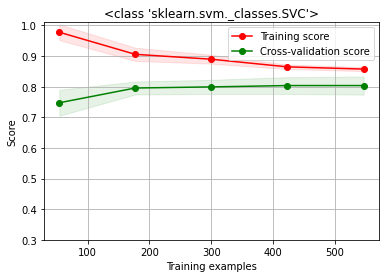

In [0]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
 
  
# defining parameter range 
param_grid = {'C': [0.01, 0.5, 1],  
              'gamma': [1, 0.1, 0.01], 
              'kernel': ['linear', 'rbf', 'poly'],
              'coef0': [0.01, 0.5, 1],
              'degree': [1, 3, 5]}  

# For now: 3 options for kernels implemented: linear rbf and poly
# Other options on kernels:
# - sampler, for example: first use RBF sampler, then linear kernel
# - manually constructed kernel function?
# - precomputed kernel
# - sigmoid kernel


grid = RandomizedSearchCV(SVC(probability=True), param_grid, refit=True, verbose=False, cv=cv_10fold) 
  
# fitting the model for grid search 
best_model = grid.fit(X_train_pca, Y_train) 
clf = grid.best_estimator_


print('Best slack parameter C:', grid.best_estimator_.get_params()['C'])
print('Best gamma:', grid.best_estimator_.get_params()['gamma'])
print('Best kernel:', grid.best_estimator_.get_params()['kernel'])
print('Best coef0:', grid.best_estimator_.get_params()['coef0'])
print('Best degree:', grid.best_estimator_.get_params()['degree'])

# Classification report (training data)
y_pred_train = clf.predict(X_train_pca)
print(classification_report(Y_train, y_pred_train))

# Classification report (test data)
y_pred_test = clf.predict(X_test_pca)
print(classification_report(Y_test, y_pred_test))

# Learning curve
plt.show()
title = str(type(clf))
fig, ax = plt.subplots()
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
plot_learning_curve(clf, title, X_train_pca, Y_train, ax, ylim=(0.3, 1.01), cv=cv)


# SVM with cross-validation

This is performed to build the classifier and get an insight in the hyperparameters. 

Iteration nr. 1 with best hyperparameters:
Best slack parameter (C): 0.05
Best gamma: 0.05
Best kernel: linear
Best coef0: 0.01
Best degree: 5
Iteration nr. 2 with best hyperparameters:
Best slack parameter (C): 1
Best gamma: 0.1
Best kernel: rbf
Best coef0: 1.2
Best degree: 0.5
Iteration nr. 3 with best hyperparameters:
Best slack parameter (C): 0.5
Best gamma: 0.05
Best kernel: poly
Best coef0: 1
Best degree: 5
Iteration nr. 4 with best hyperparameters:
Best slack parameter (C): 0.05
Best gamma: 1
Best kernel: linear
Best coef0: 0.5
Best degree: 3
Iteration nr. 5 with best hyperparameters:
Best slack parameter (C): 0.05
Best gamma: 0.01
Best kernel: linear
Best coef0: 1.2
Best degree: 5
Iteration nr. 6 with best hyperparameters:
Best slack parameter (C): 0.05
Best gamma: 0.05
Best kernel: linear
Best coef0: 0.5
Best degree: 3
Iteration nr. 7 with best hyperparameters:
Best slack parameter (C): 0.5
Best gamma: 0.01
Best kernel: linear
Best coef0: 0.01
Best degree: 1
Iteration nr. 8 wi

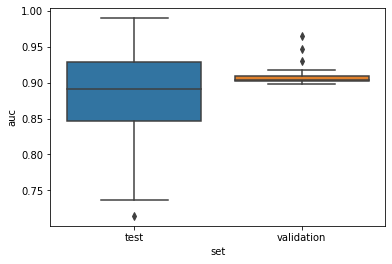

              precision    recall  f1-score   support

           0       0.79      0.69      0.74        67
           1       0.81      0.88      0.85       104

    accuracy                           0.81       171
   macro avg       0.80      0.79      0.79       171
weighted avg       0.81      0.81      0.80       171

0.8070175438596491


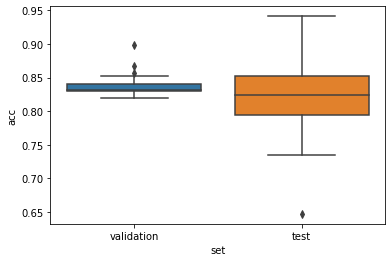

In [0]:
from sklearn.metrics import classification_report

# Create a 20 fold stratified CV iterator
cv_20fold = model_selection.StratifiedKFold(n_splits=20)
results_SVM = []
results_acc_SVM = []
best_C = []
best_gamma = []
best_kernel = []
best_coef0 = []
best_degree = []
num_SVM = 0


# Loop over the folds
for validation_index, test_index in cv_20fold.split(X_train_pca, Y_train):
    # Split the data properly
    X_validation = X_train_pca[validation_index]
    Y_validation = np.array(Y_train)[validation_index]
    
    X_test = X_train_pca[test_index]
    y_test = np.array(Y_train)[test_index]
    
    
    # Hyperparameters that we want to tune
    param_grid_SVM = {'C': [0.01, 0.05, 0.5, 1],  
              'gamma': [1.2, 1, 0.1, 0.05, 0.01], 
              'kernel': ['linear', 'rbf', 'poly'],
              'coef0': [0.01, 0.1, 0.5, 1, 1.2],
              'degree': [0.5, 1, 3, 5]}

    # Use RandomizedSearch to tune hyperparameters
    grid_SVM = RandomizedSearchCV(SVC(probability=True), param_grid_SVM, refit=True, verbose=False, cv=cv_10fold, scoring='roc_auc')  
    
    # Fit the model
    best_model_SVM = grid_SVM.fit(X_validation, Y_validation)
    clf_SVM  = grid_SVM.best_estimator_

    # Print the value of best hyperparameters
    
    num_SVM = num_SVM +1
    print(f'Iteration nr. {num_SVM} with best hyperparameters:')
    print(f'Best slack parameter (C): {clf_SVM.C}')
    print(f'Best gamma: {clf_SVM.gamma}')
    print(f'Best kernel: {clf_SVM.kernel}')
    print(f'Best coef0: {clf_SVM.coef0}')
    print(f'Best degree: {clf_SVM.degree}')

    #best_C.append(clf_SVM.C)
    #best_gamma.append(clf_SVM.gamma)
    #best_kernel.append(clf_SVM.kernel)
    #best_coef0.append(clf_SVM.coef0)
    #best_degree.append(clf_SVM.degree)
    
    # Test the classifier on the validation data
    probabilities_validation_SVM = clf_SVM.predict_proba(X_validation)
    scores_validation_SVM = probabilities_validation_SVM[:, 1]

    # Test the classifier on the test data
    probabilities_SVM = clf_SVM.predict_proba(X_test)
    scores_SVM = probabilities_SVM[:, 1]

    # Get the accuracy
    Y_pred_SVM = clf_SVM.predict(X_validation)
    accuracy_SVM=metrics.accuracy_score(Y_validation, Y_pred_SVM)
    results_acc_SVM.append({'acc': accuracy_SVM,'set': 'validation'})
    Y_pred_SVM = clf_SVM.predict(X_test)
    accuracy_SVM = metrics.accuracy_score(y_test, Y_pred_SVM)
    results_acc_SVM.append({'acc': accuracy_SVM,'set': 'test'})

    
    # Get the auc
    auc_SVM = metrics.roc_auc_score(y_test, scores_SVM)
    results_SVM.append({'auc': auc_SVM,'C': clf_SVM.C, 'gamma': clf_SVM.gamma, 
                    'kernel': clf_SVM.kernel, 'coef0': clf_SVM.coef0, 
                    'degree': clf_SVM.degree,'set': 'test'})
    
    
    
    # Get the auc
    auc_validation_SVM = metrics.roc_auc_score(Y_validation, scores_validation_SVM)
    results_SVM.append({
        'auc': auc_validation_SVM,
        'C': clf_SVM.C,
        'gamma': clf_SVM.gamma,
        'kernel': clf_SVM.kernel,
        'coef0': clf_SVM.coef0,
        'degree': clf_SVM.degree,
        'set': 'validation'
    })
    
# Create results dataframe and plot it
results_SVM = pd.DataFrame(results_SVM)
plt.show()
seaborn.boxplot(y='auc', x='set', data=results_SVM)
plt.show()
results_acc_SVM = pd.DataFrame(results_acc_SVM)
seaborn.boxplot(y='acc', x='set', data=results_acc_SVM)

#optimal_C = (np.mean(best_C))
#print(f"The optimal C={optimal_C:.1f}")
#optimal_gamma = (np.mean(best_gamma))
#print(f"The optimal gamma={optimal_gamma:.1f}")
#optimal_kernel = (most_frequent(best_kernel)) 
#print(f"The optimal kernel={optimal_kernel}")
#optimal_coef0 = (np.mean(best_coef0))
#print(f"The optimal coef0={optimal_coef0:.1f}")
#optimal_degree = (np.mean(best_degree))
#print(f"The optimal degree={optimal_degree:.1f}")

#grid = SVC(C=round(optimal_C,2), gamma=round(optimal_gamma,2), kernel=optimal_kernel,
          #coef0=round(optimal_coef0,2), degree=round(optimal_degree,2))

# fitting the model for grid search 
# clf_SVM = grid.fit(X_train_pca, Y_train) 


print(classification_report(Y_test, clf_SVM.predict(X_test_pca)))
#y_pred = clf_SVM.predict(X_test_pca)
print(clf_SVM.score(X_test_pca, Y_test))


# **Random Forrest Classifier**

The Random Forrest Classifier has 19 different hyperparameters:
- n_estimators: number of trees (to much --> overfitting)
- criterion: How to measure the quality of a split (gini) (tree-specific)
- max_depth: depth of the tree
- min_samples_split: minimum number of samples required to split an internal node
- min_samples_leaf: number of samples required to be at a node
- min_weight_fraction_leaf: sum total of the weigths at a node.
- max_features: number of features to consider
- max_leaf_nodes: 
- min_impurity_decrease: node will split if impurity decreases with this value
- min_impurity_split: A node will split if its impurity is above the threshold, otherwise it is a leaf
- bootstrap: use or not (T/F) (To improve accuracy by creating samples)
if T --> max_samples: number of samples to train each base estimator
- oob_score: use out-of-bag samples
- n_jobs: 
- random_state: 
- verbose:
- warm_start:
- class_weight: If one class is more important
- ccp_alpha: x

This is performed to build the classifier and get an insight in the hyperparameters. 




Best number of trees: 50
Best Bootstrapping: False
Best criterion: entropy
Best max depth: 13
Best min samples split: 5
Best samples leaf: 6
              precision    recall  f1-score   support

           0       0.99      0.92      0.96       269
           1       0.95      1.00      0.97       415

    accuracy                           0.97       684
   macro avg       0.97      0.96      0.96       684
weighted avg       0.97      0.97      0.97       684

              precision    recall  f1-score   support

           0       0.77      0.64      0.70        67
           1       0.79      0.88      0.83       104

    accuracy                           0.78       171
   macro avg       0.78      0.76      0.77       171
weighted avg       0.78      0.78      0.78       171



<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

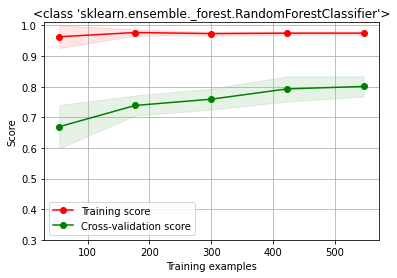

In [0]:
#Hyperparameters tuning:
n_tree = [50]                         # n_estimators
boot = ['True','False']               # Bootstrapping
criterion = ['gini','entropy']        # measure of quality
max_depth = list(range(5,16))         # Depth of the tree
min_samples_split = list(range(2,10)) # prevends overfitting
min_samples_leaf = [3,4,5,6,7]        # prevends overfitting


param_grid = {'n_estimators': n_tree,  
              'bootstrap': boot, 
              'criterion': criterion,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf} 

grid = RandomizedSearchCV(RandomForestClassifier(), param_grid, refit=True, verbose=False, cv=cv_10fold) 
  
# fitting the model for grid search 
best_model = grid.fit(X_train_pca, Y_train) 
clf = grid.best_estimator_


print('Best number of trees:', grid.best_estimator_.get_params()['n_estimators'])
print('Best Bootstrapping:', grid.best_estimator_.get_params()['bootstrap'])
print('Best criterion:', grid.best_estimator_.get_params()['criterion'])
print('Best max depth:', grid.best_estimator_.get_params()['max_depth'])
print('Best min samples split:', grid.best_estimator_.get_params()['min_samples_split'])
print('Best samples leaf:', grid.best_estimator_.get_params()['min_samples_leaf'])

# Classification report (training data)
y_pred_train = clf.predict(X_train_pca)
print(classification_report(Y_train, y_pred_train))

# Classification report (test data)
y_pred_test = clf.predict(X_test_pca)
print(classification_report(Y_test, y_pred_test))

#Learning curve
plt.show()
title = str(type(clf))
fig, ax = plt.subplots()
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
plot_learning_curve(clf, title, X_train_pca, Y_train, ax, ylim=(0.3, 1.01), cv=cv)


# **Random Forrest with Crossvalidation**

This is performed to build the classifier and get an insight in the hyperparameters. 

In [0]:
# Create a 20 fold stratified CV iterator
cv_20fold = model_selection.StratifiedKFold(n_splits=20)
results_RF = []
results_acc_RF = []
Best_n_trees = []
Best_Bootstrapping = []
Best_criterion = []
Best_max_depth = []
Best_min_samples_split = []
Best_min_samples_leaf = []

# Program to find most frequent  
# element in a list 
def most_frequent(List): 
    return max(set(List), key = List.count) 

# Loop over the folds
for validation_index, test_index in cv_20fold.split(X_train_pca, Y_train):
    # Split the data properly
    X_validation = X_train_pca[validation_index]
    Y_validation = np.array(Y_train)[validation_index]
    
    X_test_RF = X_train_pca[test_index]
    Y_test_RF = np.array(Y_train)[test_index]
    
    param_grid_RF = {'n_estimators': n_tree,  
              'bootstrap': boot, 
              'criterion': criterion,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf} 

    grid_RF = RandomizedSearchCV(RandomForestClassifier(), param_grid_RF, refit=True, 
                              verbose=False, cv=cv_20fold)
    
    best_model_RF = grid_RF.fit(X_validation, Y_validation)
    
    # Get resulting classifier
    clf_RF = grid_RF.best_estimator_

    print(f'Best number of trees: {clf_RF.n_estimators}')
    print(f'Best Bootstrapping: {clf_RF.bootstrap}')
    print(f'Best criterion: {clf_RF.criterion}')
    print(f'Best max depth: {clf_RF.max_depth}')
    print(f'Best min samples split: {clf_RF.min_samples_split}')
    print(f'Best samples leaf: {clf_RF.min_samples_leaf}')

    Best_n_trees.append(clf_RF.n_estimators)
    Best_Bootstrapping.append(clf_RF.bootstrap)
    Best_criterion.append(clf_RF.criterion)
    Best_max_depth.append(clf_RF.max_depth)
    Best_min_samples_split.append(clf_RF.min_samples_split)
    Best_min_samples_leaf.append(clf_RF.min_samples_leaf)

    # Test the classifier on the test data
    probabilities_RF = clf_RF.predict_proba(X_test_RF)
    scores_RF = probabilities_RF[:, 1]

    # Get the accuracy
    Y_pred = clf_RF.predict(X_validation)
    accuracy=metrics.accuracy_score(Y_validation, Y_pred)
    results_acc_RF.append({'acc': accuracy,'set': 'validation'})
    Y_pred = clf_RF.predict(X_test_RF)
    accuracy = metrics.accuracy_score(Y_test_RF, Y_pred)
    results_acc_RF.append({'acc': accuracy,'set': 'test'})
    
    # Get the auc
    auc_RF = metrics.roc_auc_score(Y_test_RF, scores_RF)
    results_RF.append({'auc': auc_RF,'n_estimators': clf_RF.n_estimators, 
                    'bootstrap': clf_RF.bootstrap, 
                    'criterion': clf_RF.criterion, 
                    'max_depth': clf_RF.max_depth, 
                    'min_samples_split': clf_RF.min_samples_split, 
                    'min_samples_split': clf_RF.min_samples_leaf,
                    'set': 'test'})
    
    # Test the classifier on the validation data
    probabilities_validation_RF = clf_RF.predict_proba(X_validation)
    scores_validation_RF = probabilities_validation_RF[:, 1]
    
    
# Create results dataframe and plot it
results_RF = pd.DataFrame(results_RF)
plt.show()
seaborn.boxplot(y='auc', x='set', data=results_RF)
plt.show()
results_acc_RF = pd.DataFrame(results_acc_RF)
seaborn.boxplot(y='acc', x='set', data=results_acc_RF)

optimal_n_tree = (np.mean(Best_n_trees))
print(f"The optimal number of trees={optimal_n_tree:.1f}")
optimal_bootstrap = (most_frequent(Best_Bootstrapping))
print(f"The optimal bootstrap={optimal_bootstrap}")
optimal_criterion = (most_frequent(Best_criterion)) 
print(f"The optimal criterion={optimal_criterion}")
optimal_max_depth = (np.mean(Best_max_depth))
print(f"The optimal max depth={optimal_max_depth:.1f}")
optimal_min_samples_split = (np.mean(Best_min_samples_split))
print(f"The optimal min samples split={optimal_min_samples_split:.1f}")
optimal_min_samples_leaf = (np.mean(Best_min_samples_leaf))
print(f"The optimal min samples leaf={optimal_min_samples_leaf:.1f}")

grid_RF = RandomForestClassifier(n_estimators=int(round(optimal_n_tree)), 
                              bootstrap=optimal_bootstrap, 
                              criterion=optimal_criterion, 
                              max_depth=int(round(optimal_max_depth)), 
                              min_samples_split=int(round(optimal_min_samples_split)), 
                              min_samples_leaf=int(round(optimal_min_samples_leaf)))

# fitting the model for grid search 
clf_RF = grid_RF.fit(X_train_pca, Y_train) 

from sklearn.metrics import classification_report

print(classification_report(Y_test, clf_RF.predict(X_test_pca)))
#y_pred = clf_RF.predict(X_test_pca)
print(clf_RF.score(X_test_pca, Y_test))

NameError: ignored

# **Combined Cross Validation With Voting**




## **Functions**

In [0]:
def plot_learning_curve(estimator, title, X, y, axes, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores  = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                       test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="best")

    return plt

def pca_selection(X_train_scaled, X_test_scaled):
  
  # Fitting the PCA algorithm with the Data
  pca = PCA().fit(X_train_scaled)
  var = np.cumsum(pca.explained_variance_ratio_) 
  n_components = np.where(var > 0.95)[0][0]
  print(f"Nr. of components:{n_components}")
  # Perform a PCA
  pca = decomposition.PCA(n_components=n_components)
  pca.fit(X_train_scaled)
  X_val_pca = pca.transform(X_train_scaled)
  X_test_pca = pca.transform(X_test_scaled)
  return X_validation, X_test

def RFpca_selection(X_train_scaled, X_test_scaled, Y_train):
  # Feature Importance with Random Forest
  clf = ExtraTreesClassifier(n_estimators=50)
  clf = clf.fit(X_train_scaled, Y_train)
  clf.feature_importances_ 
  model = SelectFromModel(clf, prefit=True, threshold= "mean")
  X_new = model.transform(X_train_scaled)
  X_new_test = model.transform(X_test_scaled)

  # PCA 
  pca = PCA().fit(X_new)
  var = np.cumsum(pca.explained_variance_ratio_) 
  n_components = np.where(var > 0.95)[0][0]
  pca = decomposition.PCA(n_components=n_components)
  pca.fit(X_new)
  X_val_pca = pca.transform(X_new)
  X_test_pca = pca.transform(X_new_test)
  return X_validation, X_test

def classifier_kNN(cv_10fold, X_validation, Y_validation, X_test, Y_test):
    # Hyperparameters that we want to tune. (kNN)
    leaf_size = list(range(20,40))
    n_neighbors = list(range(5,50))
    p=[1,2]
    hyperparameters_kNN = dict(n_neighbors=n_neighbors, p=p,leaf_size=leaf_size)

    #Create kNN object
    knn = neighbors.KNeighborsClassifier()

    #Use RandomizedSearch to tune hyperparameters
    random_search_kNN = model_selection.RandomizedSearchCV(knn, hyperparameters_kNN, cv=cv_10fold)

    #Fit the model
    best_model_kNN = random_search_kNN.fit(X_validation,Y_validation)
    clf_kNN = random_search_kNN.best_estimator_
    clf_kNN.fit(X_validation, Y_validation)
    
    # Test the classifier on the validation data
    probabilities_validation_kNN = clf_kNN.predict_proba(X_validation)
    scores_validation_kNN = probabilities_validation_kNN[:, 1]
    
    # Test the classifier on the test data
    probabilities_kNN = clf_kNN.predict_proba(X_test)
    scores_kNN = probabilities_kNN[:, 1]

    # Get the accuracy
    y_pred_kNN = clf_kNN.predict(X_test)
    accuracy_kNN = metrics.accuracy_score(Y_test, y_pred_kNN)
    results_acc_kNN.append({'acc': accuracy_kNN,'set': 'test'})
    y_pred_kNN = clf_kNN.predict(X_validation)
    accuracy_kNN=metrics.accuracy_score(Y_validation, y_pred_kNN)
    results_acc_kNN.append({'acc': accuracy_kNN,'set': 'validation'})
    
    # Get the auc
    auc_kNN = metrics.roc_auc_score(Y_test, scores_kNN)
    results_kNN.append({'auc': auc_kNN,'k': clf_kNN.n_neighbors,'set': 'test'})       
    
    # Get the auc
    auc_validation_kNN = metrics.roc_auc_score(Y_validation, scores_validation_kNN)
    results_kNN.append({'auc': auc_validation_kNN,'k': clf_kNN.n_neighbors,'set': 'validation'})

    # Get the F1-score (test)
    y_pred_kNN = clf_kNN.predict(X_test)
    F1_kNN = metrics.f1_score(Y_test, y_pred_kNN, average='macro') 
    results_F1_kNN.append({'F1': F1_kNN, 'set': 'test'})

    # Get the F1-Score (validation)
    y_pred_kNN = clf_kNN.predict(X_validation)
    F1_validation_kNN = metrics.f1_score(Y_validation, y_pred_kNN, average='macro') 
    results_F1_kNN.append({'F1': F1_validation_kNN, 'set': 'validation'})


    # The value of best Hyperparameters
    kNN_table.append({'auc': auc_kNN, 'acc' : accuracy_kNN, 'F1': F1_kNN,
                    'leaf_size' : best_model_kNN.best_estimator_.get_params()['leaf_size'],
                    'p' : best_model_kNN.best_estimator_.get_params()['p'],
                    'n_neigbors': best_model_kNN.best_estimator_.get_params()['n_neighbors']})
    
    return clf_kNN, results_acc_kNN, results_kNN, results_F1_kNN, kNN_table


def classifier_SVM(cv_10fold, X_validation, Y_validation, X_test, Y_test):
    # Hyperparameters that we want to tune
    param_grid_SVM = {'C': [1, 1.5, 2.0, 2.2],  
              #'gamma': [1.2, 1, 0.1, 0.05, 0.01],  We tried to use these parameters, but it didn't give the results
              #'kernel': ['linear', 'rbf', 'poly'],
              'coef0': [1.4, 1.6, 1.8, 2.0, 2.2],
              'degree': [1, 3, 5, 6, 7, 9, 11]}

              
    # Use RandomizedSearch to tune hyperparameters
    grid_SVM = RandomizedSearchCV(SVC(probability=True, kernel='poly', gamma='scale'), param_grid_SVM, refit=True, 
                                  verbose=False, cv=cv_10fold)  
    


    # Fit the model
    best_model_SVM = grid_SVM.fit(X_validation, Y_validation)
    clf_SVM = grid_SVM.best_estimator_
    clf_SVM.fit(X_validation, Y_validation)

    # Test the classifier on the validation data
    probabilities_validation_SVM = clf_SVM.predict_proba(X_validation)
    scores_validation_SVM = probabilities_validation_SVM[:, 1]

    # Test the classifier on the test data
    probabilities_SVM = clf_SVM.predict_proba(X_test)
    scores_SVM = probabilities_SVM[:, 1]

    # Get the accuracy
    Y_pred_SVM = clf_SVM.predict(X_test)
    accuracy_SVM_test = metrics.accuracy_score(Y_test, Y_pred_SVM)
    results_acc_SVM.append({'acc': accuracy_SVM_test,'set': 'test'})
    Y_pred_SVM = clf_SVM.predict(X_validation)
    accuracy_SVM=metrics.accuracy_score(Y_validation, Y_pred_SVM)
    results_acc_SVM.append({'acc': accuracy_SVM,'set': 'validation'})

    # Get the auc
    auc_SVM = metrics.roc_auc_score(Y_test, scores_SVM)
    results_SVM.append({'auc': auc_SVM,'set': 'test'})
    
    # Get the auc
    auc_validation_SVM = metrics.roc_auc_score(Y_validation, scores_validation_SVM)
    results_SVM.append({
        'auc': auc_validation_SVM, 'set': 'validation'})
    
    # Get the F1-score (test)
    y_pred_SVM = clf_SVM.predict(X_test)
    F1_SVM = metrics.f1_score(Y_test, y_pred_SVM, average='macro') 
    results_F1_SVM.append({'F1': F1_SVM, 'set': 'test'})

    # Get the F1-Score (validation)
    y_pred_SVM = clf_SVM.predict(X_validation)
    F1_validation_SVM = metrics.f1_score(Y_validation, y_pred_SVM, average='macro') 
    results_F1_SVM.append({'F1': F1_validation_SVM, 'set': 'validation'})

    SVM_table.append({'C': clf_SVM.C,
        #'gamma': clf_SVM.gamma,
        #'kernel': clf_SVM.kernel,
        'coef0': clf_SVM.coef0,
        'degree': clf_SVM.degree,
        'auc': auc_SVM,
        'acc': accuracy_SVM_test,
        'F1': F1_SVM})

    return clf_SVM, results_acc_SVM, results_SVM, results_F1_SVM, SVM_table

    


def classifier_RF(cv_10fold, X_validation, Y_validation, X_test, Y_test):
    n_tree = [5, 10, 20, 30]              # N_estimators
    boot = ['True']                       # Bootstrapping
    criterion = ['entropy']               # Measure of quality
    max_depth = list(range(5,16))         # Depth of the tree
    min_samples_split = list(range(2,10)) # Prevents overfitting
    min_samples_leaf = [3,4,5,6,7]        # Prevents overfitting

    param_grid_RF = {'n_estimators': n_tree,  
              'bootstrap': boot, 
              'criterion': criterion,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf} 

    grid_RF = RandomizedSearchCV(RandomForestClassifier(), param_grid_RF, refit=True, 
                              verbose=False, cv=cv_10fold)
    
    best_model_RF = grid_RF.fit(X_validation, Y_validation)

    
    # Get resulting classifier
    clf_RF = grid_RF.best_estimator_
    clf_RF.fit(X_validation, Y_validation)

    # Test the classifier on the test data
    probabilities_RF = clf_RF.predict_proba(X_test)
    scores_RF = probabilities_RF[:, 1]
    
    # Get the accuracy
    Y_pred = clf_RF.predict(X_test)
    accuracy_test = metrics.accuracy_score(Y_test, Y_pred)
    results_acc_RF.append({'acc': accuracy_test,'set': 'test'})
    Y_pred = clf_RF.predict(X_validation)
    accuracy=metrics.accuracy_score(Y_validation, Y_pred)
    results_acc_RF.append({'acc': accuracy,'set': 'validation'})
    
    # Get the auc
    auc_RF = metrics.roc_auc_score(Y_test, scores_RF)
    results_RF.append({'auc': auc_RF, 'set': 'test'})

    # Get the F1-score (test)
    y_pred_RF = clf_RF.predict(X_test)
    F1_RF = metrics.f1_score(Y_test, y_pred_RF, average='macro') 
    results_F1_RF.append({'F1': F1_RF, 'set': 'test'})

    # Get the F1-Score (validation)
    y_pred_RF = clf_RF.predict(X_validation)
    F1_validation_RF = metrics.f1_score(Y_validation, y_pred_RF, average='macro') 
    results_F1_RF.append({'F1': F1_validation_RF, 'set': 'validation'})
        
    # Test the classifier on the validation data
    probabilities_validation_RF = clf_RF.predict_proba(X_validation)
    scores_validation_RF = probabilities_validation_RF[:, 1]
    auc_RF_val = metrics.roc_auc_score(Y_validation, scores_validation_RF)
    results_RF.append({'auc': auc_RF_val, 'set': 'validation'})

    RF_table.append({'n_estimators': clf_RF.n_estimators, 
                    'bootstrap': clf_RF.bootstrap, 
                    'criterion': clf_RF.criterion, 
                    'max_depth': clf_RF.max_depth, 
                    'min_samples_split': clf_RF.min_samples_split, 
                    'min_samples_leaf': clf_RF.min_samples_leaf,
                    'acc':accuracy_test,
                    'auc':auc_RF,
                     'F1': F1_RF})

    return clf_RF, results_acc_RF, results_RF, results_F1_RF, RF_table



# Voting results 

def votingresults(clf_vote_kNN_SVM_RF, X_validation, Y_validation, X_test, Y_test):
    clf_vote_kNN_SVM_RF.fit(X_validation, Y_validation)

    # Get the accuracy
    Y_pred = clf_vote_kNN_SVM_RF.predict(X_test)
    accuracy = metrics.accuracy_score(Y_test, Y_pred)
    results_acc_vote_kNN_SVM_RF.append({'acc': accuracy,'set': 'test'})
    Y_pred = clf_vote_kNN_SVM_RF.predict(X_validation)
    accuracy=metrics.accuracy_score(Y_validation, Y_pred)
    results_acc_vote_kNN_SVM_RF.append({'acc': accuracy,'set': 'validation'})
  
    # Test the classifier on the test data
    probabilities_vote = clf_vote_kNN_SVM_RF.predict_proba(X_test)
    scores_vote = probabilities_vote[:, 1]

    # Get the auc
    auc_vote = metrics.roc_auc_score(Y_test, scores_vote)
    results_vote_kNN_SVM_RF.append({'auc': auc_vote, 'set': 'test'})

    # Test the classifier on the validation data
    probabilities_vote = clf_vote_kNN_SVM_RF.predict_proba(X_validation)
    scores_vote = probabilities_vote[:, 1]

    # Get the auc
    auc_vote = metrics.roc_auc_score(Y_validation, scores_vote)
    results_vote_kNN_SVM_RF.append({'auc': auc_vote, 'set': 'validation'})

    # Get the F1-score (test)
    y_pred_vote = clf_vote_kNN_SVM_RF.predict(X_test)
    F1_vote = metrics.f1_score(Y_test, y_pred_vote, average='macro') 
    results_F1_vote_kNN_SVM_RF.append({'F1': F1_vote, 'set': 'test'})

    # Get the F1-Score (validation)
    y_pred_vote = clf_vote_kNN_SVM_RF.predict(X_validation)
    F1_validation_vote = metrics.f1_score(Y_validation, y_pred_vote, average='macro') 
    results_F1_vote_kNN_SVM_RF.append({'F1': F1_validation_vote, 'set': 'validation'})

    return results_acc_vote_kNN_SVM_RF, results_vote_kNN_SVM_RF, results_F1_vote_kNN_SVM_RF



**Loop test**


In [0]:
# Create a 20 fold stratified CV iterator
cv_10fold = model_selection.StratifiedKFold(n_splits=10)
cv_20fold = model_selection.StratifiedKFold(n_splits=20)

# Lists for KNN
results_kNN = []
results_acc_kNN = []
results_F1_kNN = []
kNN_table = []

# Lists for SVM
results_SVM = []
results_acc_SVM = []
results_F1_SVM = []
SVM_table = []
best_C = []


# Lists for RF
results_RF = []
results_acc_RF = []
results_F1_RF = []
RF_table = []

# Lists for voting (kNN, SVM, RF)
results_acc_vote_kNN_SVM_RF = []
results_vote_kNN_SVM_RF = []
results_F1_vote_kNN_SVM_RF = []


# Check the loop
n = 0

# Program to find most frequent  
# element in a list 
def most_frequent(List): 
    return max(set(List), key = List.count) 

# OUTER CV
for validation_index, test_index in cv_20fold.split(X, Y):
    
    X_validation = np.array(X)[validation_index]
    Y_validation = np.array(Y)[validation_index]
    
    X_test = np.array(X)[test_index]
    Y_test = np.array(Y)[test_index]

    print(X_test.shape)

    # Scaling
    scaler = preprocessing.StandardScaler()
    scaler.fit(X_validation)
    X_val_scaled = scaler.transform(X_validation)
    X_test_scaled = scaler.transform(X_test)

    # Feature selection
    X_validation, X_test = RFpca_selection(X_val_scaled, X_test_scaled, Y_validation)

    # # ** kNN **
    clf_kNN, results_acc_kNN, results_kNN, results_F1_kNN, kNN_table = classifier_kNN(cv_10fold, X_validation, Y_validation, X_test, Y_test)

    # ** SVM **
    clf_SVM, results_acc_SVM, results_SVM, results_F1_SVM, SVM_table = classifier_SVM(cv_10fold, X_validation, Y_validation, X_test, Y_test)
   
    # # ** Random Forest **
    clf_RF, results_acc_RF, results_RF, results_F1_RF, RF_table = classifier_RF(cv_10fold, X_validation, Y_validation, X_test, Y_test)
    
    # # ** Voting **
    clf_vote_kNN_SVM_RF = VotingClassifier(
         estimators=[('KNN', clf_kNN), ('RF', clf_RF), ('SVM', clf_SVM)],
         voting='soft')
    
    # Plot voting results (kNN, SVM, RF)
    results_acc_vote_kNN_SVM_RF, results_vote_kNN_SVM_RF, results_F1_vote_kNN_SVM_RF = votingresults(clf_vote_kNN_SVM_RF, X_validation, Y_validation, X_test, Y_test)
    
    n = n+1
    print(n)

# Plot all results
from IPython.display import display
# Create results dataframe and plot it (KNN)
kNN_table = pd.DataFrame(kNN_table)
print('Hyperparameters KNN')
display(kNN_table)
results_kNN = pd.DataFrame(results_kNN)
plt.figure(figsize=(20,20))
plt.subplot(531)
plt.title('auc kNN')
seaborn.boxplot(y='auc', x='set', data=results_kNN)
plt.subplot(532)
plt.title('accuracy kNN')
results_acc_kNN = pd.DataFrame(results_acc_kNN)
seaborn.boxplot(y='acc', x='set', data=results_acc_kNN)
plt.subplot(533)
plt.title('F1-score kNN')
results_F1_kNN = pd.DataFrame(results_F1_kNN)
seaborn.boxplot(y='F1', x='set', data=results_F1_kNN)

# Create results dataframe and plot it (SVM)
SVM_table = pd.DataFrame(SVM_table)
print('Hyperparameters SVM')
display(SVM_table)
results_SVM = pd.DataFrame(results_SVM)
plt.subplot(534)
plt.title('auc SVM')
seaborn.boxplot(y='auc', x='set', data=results_SVM)
plt.subplot(535)
plt.title('accuracy SVM')
results_acc_SVM = pd.DataFrame(results_acc_SVM)
seaborn.boxplot(y='acc', x='set', data=results_acc_SVM)
plt.subplot(536)
plt.title('F1-score SVM')
results_F1_SVM = pd.DataFrame(results_F1_SVM)
seaborn.boxplot(y='F1', x='set', data=results_F1_SVM)

# Create results dataframe and plot it (RF)
RF_table = pd.DataFrame(RF_table)
print('Hyperparameters RF')
display(RF_table)
results_RF = pd.DataFrame(results_RF)
plt.subplot(537)
plt.title('auc RF')
seaborn.boxplot(y='auc', x='set', data=results_RF)
plt.subplot(538)
plt.title('accuracy RF')
results_acc_RF = pd.DataFrame(results_acc_RF)
seaborn.boxplot(y='acc', x='set', data=results_acc_RF)
plt.subplot(539)
plt.title('F1-score RF')
results_F1_RF = pd.DataFrame(results_F1_RF)
seaborn.boxplot(y='F1', x='set', data=results_F1_RF)

# Create voting results dataframe and plot it (kNN, SVM, RF)
results_vote_kNN_SVM_RF = pd.DataFrame(results_vote_kNN_SVM_RF)
plt.subplot(5,3,10)
plt.title('auc voting kNN, SVM, RF')
seaborn.boxplot(y='auc', x='set', data=results_vote_kNN_SVM_RF)
plt.subplot(5,3,11)
plt.title('accuracy voting kNN, SVM, RF')
results_acc_vote_kNN_SVM_RF = pd.DataFrame(results_acc_vote_kNN_SVM_RF)
seaborn.boxplot(y='acc', x='set', data=results_acc_vote_kNN_SVM_RF)
plt.subplot(5,3,12)
plt.title('F1-score voting kNN, SVM, RF')
results_F1_vote_kNN_SVM_RF = pd.DataFrame(results_F1_vote_kNN_SVM_RF)
seaborn.boxplot(y='F1', x='set', data=results_F1_vote_kNN_SVM_RF)



(39, 263)


Plotting Learning Curves

In [0]:
leaf_size_freq = most_frequent(list(kNN_table.leaf_size))
p_freq = most_frequent(list(kNN_table.p))
n_neighbors_freq = most_frequent(list(kNN_table.n_neigbors))
print(leaf_size_freq)
print(p_freq)
print(n_neighbors_freq)

C_freq = most_frequent(list(SVM_table.C))
coef0_freq = most_frequent(list(SVM_table.coef0))
degree_freq = most_frequent(list(SVM_table.degree))
print(C_freq)
print(coef0_freq)
print(degree_freq)

n_estimators_freq = most_frequent(list(RF_table.n_estimators))
bootstrap_freq = most_frequent(list(RF_table.bootstrap))
criterion_freq = most_frequent(list(RF_table.criterion))
max_depth_freq = most_frequent(list(RF_table.max_depth))
min_samples_split_freq = most_frequent(list(RF_table.min_samples_split))
min_samples_leaf_freq = most_frequent(list(RF_table.min_samples_leaf))
print(n_estimators_freq)
print(bootstrap_freq)
print(criterion_freq)
print(max_depth_freq)
print(min_samples_split_freq)
print(min_samples_leaf_freq)
 



38
1
47
1.5
1.6
9
20
True
entropy
8
2
5


TypeError: ignored

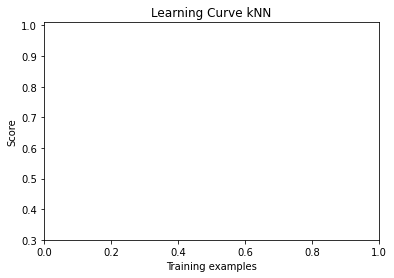

In [0]:
#X_total = list(X_validation)
#X_total = X_total.append(X_test)
#X_total = np.array(X_total)

#Y_total = list(Y_validation)
#Y_total = Y_total.append(Y_test)
#Y_total = np.array(Y_total)

#print(type(X_total))

# Scaling
#scaler = preprocessing.StandardScaler()
#scaler.fit(X_validation)
#X_val_scaled = scaler.transform(X)
#X_test_scaled = scaler.transform(X_test)

# Feature selection
#X_validation, X_test = RFpca_selection(X_val_scaled, X_test_scaled, Y_validation)

# Learning curve kNN
plt.show()
title = ('Learning Curve kNN')
leaf_size_freq = most_frequent(list(kNN_table.leaf_size))
p_freq = most_frequent(list(kNN_table.p))
n_neighbors_freq = most_frequent(list(kNN_table.n_neigbors))
clf_kNN = KNeighborsClassifier(leaf_size=leaf_size_freq, p=p_freq, n_neighbors=n_neighbors_freq)
fig, ax = plt.subplots()
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
plot_learning_curve(clf_kNN, title, X_total, Y_total, ax, ylim=(0.3, 1.01), cv=cv)


# Learning curve SVM
plt.show()
title = ('Learning Curve SVM')
C_freq = most_frequent(list(SVM_table.C))
coef0_freq = most_frequent(list(SVM_table.coef0))
degree_freq = most_frequent(list(SVM_table.degree))
clf_SVM = SVC(C=C_freq, coef0=coef0_freq, degree=degree_freq)
fig, ax = plt.subplots()
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
plot_learning_curve(clf_SVM, title, X_total, Y_total, ax, ylim=(0.3, 1.01), cv=cv)

# Learning curve RF
plt.show()
title = ('Learning Curve RF')
n_estimators_freq = most_frequent(list(RF_table.n_estimators))
bootstrap_freq = most_frequent(list(RF_table.bootstrap))
criterion_freq = most_frequent(list(RF_table.criterion))
max_depth_freq = most_frequent(list(RF_table.max_depth))
min_samples_split_freq = most_frequent(list(RF_table.min_samples_split))
clf_RF = RandomForestClassifier(n_estimators=n_estimators_freq, bootstrap=bootstrap_freq , criterion=criterion_freq, max_depth=max_depth_freq, min_samples_split=min_samples_split_freq)
fig, ax = plt.subplots()
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
plot_learning_curve(clf_RF, title, X_total, Y_total, ax, ylim=(0.3, 1.01), cv=cv)







**Loop reserve**

        auc       acc  leaf_size  p  n_neigbors
0  0.869255  0.824818         24  1          28
1  0.786814  0.773723         28  1          18
2  0.895136  0.729927         19  1          25
3  0.826528  0.759124         49  1          20
4  0.917254  0.830882         31  1          26


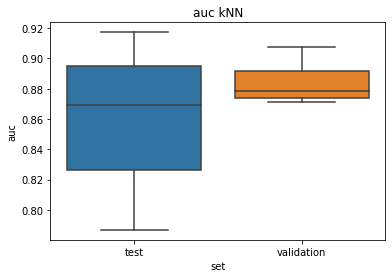

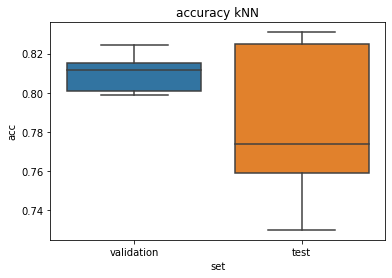

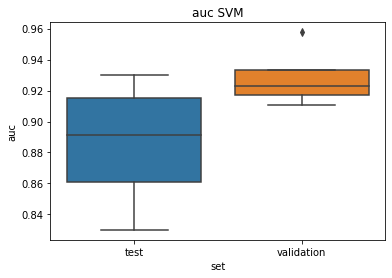

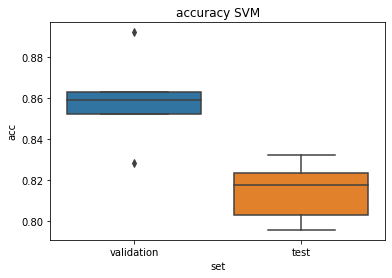

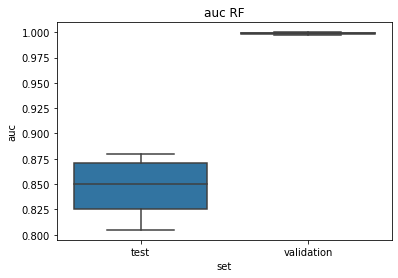

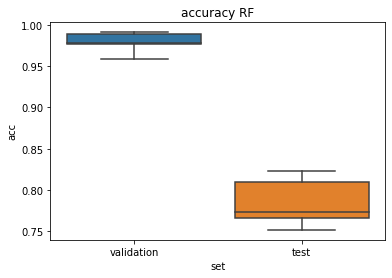

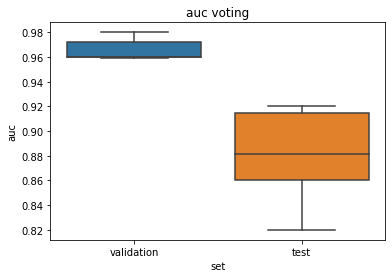

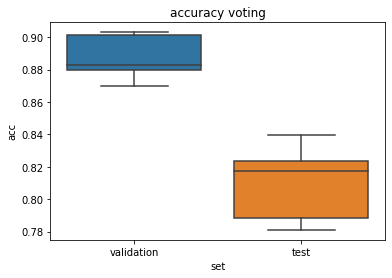

In [0]:
# Create a 20 fold stratified CV iterator
cv_20fold = model_selection.StratifiedKFold(n_splits=5)
# Lists for KNN
results_kNN = []
results_acc_kNN = []
# TABEL VOOR HYPERPARAMETERS
kNN_table = []

# Lists for SVM
results_SVM = []
results_acc_SVM = []
best_C = []
best_gamma = []
best_kernel = []
best_coef0 = []
best_degree = []

# Lists for RF
results_RF = []
results_acc_RF = []
Best_n_trees = []
Best_Bootstrapping = []
Best_criterion = []
Best_max_depth = []
Best_min_samples_split = []
Best_min_samples_leaf = []
RF_table = []

# Lists for voting
results_acc_vote = []
results_vote = []

# Program to find most frequent  
# element in a list 
def most_frequent(List): 
    return max(set(List), key = List.count) 

# Loop over the folds (KNN)
for validation_index, test_index in cv_20fold.split(X_train_pca, Y_train):
    # Split the data properly
    X_validation = X_train_pca[validation_index]
    Y_validation = np.array(Y_train)[validation_index]
    
    X_test = X_train_pca[test_index]
    Y_test = np.array(Y_train)[test_index]

    # ** kNN **
    clf_kNN, results_acc_kNN, results_kNN, kNN_table = classifier_kNN(cv_20fold, X_validation, Y_validation, X_test, Y_test)

    # ** SVM **
    clf_SVM, results_acc_SVM, results_SVM = classifier_SVM(cv_20fold, X_validation, Y_validation, X_test, Y_test)

    # ** Random Forest **
    clf_RF, results_acc_RF, results_RF, RF_table = classifier_RF(cv_20fold, X_validation, Y_validation, X_test, Y_test)
    
    # ** Voting **
    clf_vote = VotingClassifier(
        estimators=[('KNN', clf_kNN), ('SVM', clf_SVM), ('RF', clf_RF)],
        voting='soft')
    
    # Plot voting results
    results_acc_vote, results_vote = votingresults(clf_vote, X_validation, Y_validation, X_test, Y_test)


# Plot all results
# Create results dataframe and plot it (KNN)
kNN_table = pd.DataFrame(kNN_table)
print(kNN_table)
results_kNN = pd.DataFrame(results_kNN)
plt.show()
plt.title('auc kNN')
seaborn.boxplot(y='auc', x='set', data=results_kNN)
plt.show()
plt.title('accuracy kNN')
results_acc_kNN = pd.DataFrame(results_acc_kNN)
seaborn.boxplot(y='acc', x='set', data=results_acc_kNN)


# Create results dataframe and plot it (SVM)
results_SVM = pd.DataFrame(results_SVM)
plt.show()
plt.title('auc SVM')
seaborn.boxplot(y='auc', x='set', data=results_SVM)
plt.show()
plt.title('accuracy SVM')
results_acc_SVM = pd.DataFrame(results_acc_SVM)
seaborn.boxplot(y='acc', x='set', data=results_acc_SVM)

#optimal_C = (np.mean(best_C))
#print(f"The optimal C={optimal_C:.1f}")
#optimal_gamma = (np.mean(best_gamma))
#print(f"The optimal gamma={optimal_gamma:.1f}")
#optimal_kernel = (most_frequent(best_kernel)) 
#print(f"The optimal kernel={optimal_kernel}")
#optimal_coef0 = (np.mean(best_coef0))
#print(f"The optimal coef0={optimal_coef0:.1f}")
#optimal_degree = (np.mean(best_degree))
#print(f"The optimal degree={optimal_degree:.1f}")

#grid = SVC(C=round(optimal_C,2), gamma=round(optimal_gamma,2), kernel=optimal_kernel,
          #coef0=round(optimal_coef0,2), degree=round(optimal_degree,2))

# fitting the model for grid search 
# clf_SVM = grid.fit(X_train_pca, Y_train) 




# Create results dataframe and plot it (RF)
# Create results dataframe and plot it
results_RF = pd.DataFrame(results_RF)
plt.show()
plt.title('auc RF')
seaborn.boxplot(y='auc', x='set', data=results_RF)
plt.show()
plt.title('accuracy RF')
results_acc_RF = pd.DataFrame(results_acc_RF)
seaborn.boxplot(y='acc', x='set', data=results_acc_RF)

# Create voting results dataframe and plot it
results_vote = pd.DataFrame(results_vote)
plt.show()
plt.title('auc voting')
seaborn.boxplot(y='auc', x='set', data=results_vote)
plt.show()
plt.title('accuracy voting')
results_acc_vote = pd.DataFrame(results_acc_vote)
seaborn.boxplot(y='acc', x='set', data=results_acc_vote)


# optimal_n_tree = (np.mean(Best_n_trees))
# print(f"The optimal number of trees={optimal_n_tree:.1f}")
# optimal_bootstrap = (most_frequent(Best_Bootstrapping))
# print(f"The optimal bootstrap={optimal_bootstrap}")
# optimal_criterion = (most_frequent(Best_criterion)) 
# print(f"The optimal criterion={optimal_criterion}")
# optimal_max_depth = (np.mean(Best_max_depth))
# print(f"The optimal max depth={optimal_max_depth:.1f}")
# optimal_min_samples_split = (np.mean(Best_min_samples_split))
# print(f"The optimal min samples split={optimal_min_samples_split:.1f}")
# optimal_min_samples_leaf = (np.mean(Best_min_samples_leaf))
# print(f"The optimal min samples leaf={optimal_min_samples_leaf:.1f}")

# grid_RF = RandomForestClassifier(n_estimators=int(round(optimal_n_tree)), 
#                               bootstrap=optimal_bootstrap, 
#                               criterion=optimal_criterion, 
#                               max_depth=int(round(optimal_max_depth)), 
#                               min_samples_split=int(round(optimal_min_samples_split)), 
#                               min_samples_leaf=int(round(optimal_min_samples_leaf)))

# # fitting the model for grid search 
# clf_RF = grid_RF.fit(X_train_pca, Y_train) 



#clf_vote = VotingClassifier(
#    estimators=[clf_kNN(), clf_SVM(), clf_RF()],
#    voting='soft')

# print(classification_report(Y_test, clf_vote.predict(X_test_pca)))
# #y_pred = clf_RF.predict(X_test_pca)
# print(clf_vote.score(X_test_pca, Y_test))

In [0]:
cv_20fold = model_selection.StratifiedKFold(n_splits=20)
print (cv_20fold)

StratifiedKFold(n_splits=20, random_state=None, shuffle=False)
